In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import roc_curve, auc

import shap
shap.initjs()

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# dataset from ranked challenger last updated 2020
df = pd.read_csv("ranked_challenger.csv")
df.head()

,gameId,gameDuraton,blueWins,blueFirstBlood,blueFirstTower,blueFirstBaron,blueFirstDragon,blueFirstInhibitor,blueDragonKills,blueBaronKills,...,redAssist,redChampionDamageDealt,redTotalGold,redTotalMinionKills,redTotalLevel,redAvgLevel,redJungleMinionKills,redKillingSpree,redTotalHeal,redObjectDamageDealt
0,4247263043,1323,0,1,0,0,0,0,0,0,...,68,73016,49832,533,64,12.8,138,8,38711,60463
1,4247155821,1317,1,0,0,0,1,0,2,0,...,8,44218,37136,571,59,11.8,134,3,24829,14105
2,4243963257,932,0,0,0,0,0,0,0,0,...,20,30797,35364,400,50,10.0,89,5,12589,45201
3,4241678498,2098,0,0,0,1,1,0,1,1,...,72,125866,70528,832,84,16.8,205,9,65312,88202
4,4241538868,2344,1,1,1,1,1,1,2,2,...,83,131536,74596,794,85,17.0,227,7,86431,64141


In [4]:
# drop gameID and repeating features for red side
X = df.loc[:,["gameDuraton", "blueFirstBlood", "blueFirstTower", "blueFirstBaron", "blueFirstDragon", "blueFirstInhibitor",
          "blueDragonKills", "blueBaronKills", "blueTowerKills", "blueInhibitorKills", "blueWardPlaced", "blueWardkills",
         "blueKills", "blueDeath", "blueAssist", "blueChampionDamageDealt", "blueTotalGold", "blueTotalMinionKills",
         "blueTotalLevel", "blueAvgLevel", "blueJungleMinionKills", "blueKillingSpree", "blueTotalHeal", "blueObjectDamageDealt"]]

y = df["blueWins"]

In [5]:
# blue team
blue_df = df.iloc[0: ,1:26]
blue_df.head()

,gameDuraton,blueWins,blueFirstBlood,blueFirstTower,blueFirstBaron,blueFirstDragon,blueFirstInhibitor,blueDragonKills,blueBaronKills,blueTowerKills,...,blueAssist,blueChampionDamageDealt,blueTotalGold,blueTotalMinionKills,blueTotalLevel,blueAvgLevel,blueJungleMinionKills,blueKillingSpree,blueTotalHeal,blueObjectDamageDealt
0,1323,0,1,0,0,0,0,0,0,0,...,22,56039,37001,440,56,11.2,105,4,31035,5675
1,1317,1,0,0,0,1,0,2,0,4,...,31,60243,41072,531,63,12.6,111,3,26397,45303
2,932,0,0,0,0,0,0,0,0,0,...,8,24014,22929,306,42,8.4,64,0,6567,5651
3,2098,0,0,0,1,1,0,1,1,2,...,45,101607,63447,774,80,16.0,226,3,24718,31019
4,2344,1,1,1,1,1,1,2,2,11,...,47,134826,74955,831,83,16.6,252,5,37161,95287


In [6]:
X, y = blue_df.drop(['blueWins'], axis=1), blue_df.blueWins

xgb_full = xgb.DMatrix(X, label=y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
xgb_train = xgb.DMatrix(X_train, label=y_train)
xgb_test = xgb.DMatrix(X_test, label=y_test)

In [7]:
xgBoost = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=4,
              min_child_weight=7, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
params = dict(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=4,
              min_child_weight=7, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [8]:
model = xgb.train(params, xgb_train, evals=[(xgb_test, "test")], verbose_eval=1000)

# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

[20:26:06] WARNING: ../src/learner.cc:573: 
Parameters: { "importance_type", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	test-rmse:0.37893
[9]	test-rmse:0.16697


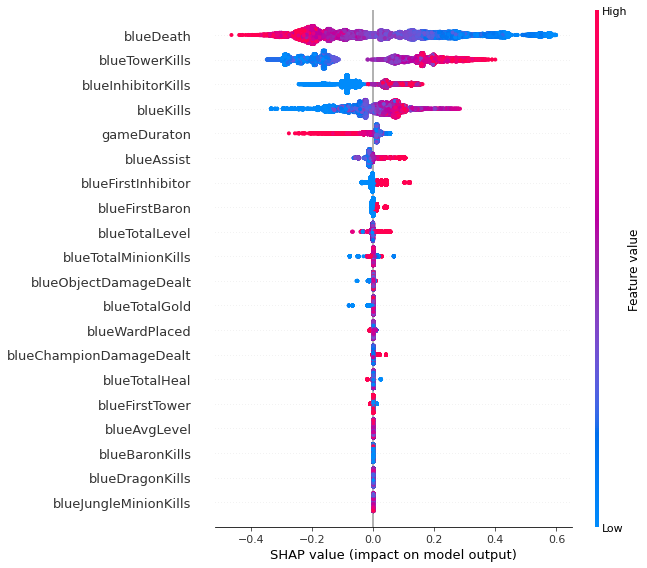

<Figure size 432x288 with 0 Axes>

In [12]:
shap.summary_plot(shap_values, X)
plt.savefig('shap.png');

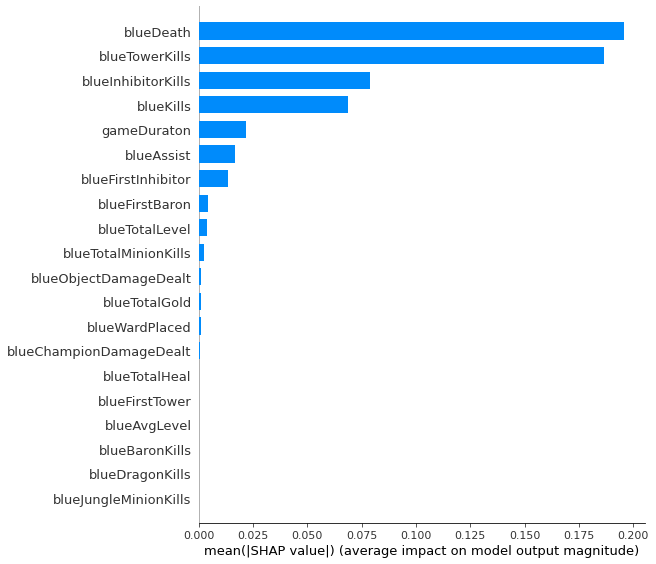

<Figure size 432x288 with 0 Axes>

In [16]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

In [10]:
blue_df 

,gameDuraton,blueWins,blueFirstBlood,blueFirstTower,blueFirstBaron,blueFirstDragon,blueFirstInhibitor,blueDragonKills,blueBaronKills,blueTowerKills,...,blueAssist,blueChampionDamageDealt,blueTotalGold,blueTotalMinionKills,blueTotalLevel,blueAvgLevel,blueJungleMinionKills,blueKillingSpree,blueTotalHeal,blueObjectDamageDealt
0,1323,0,1,0,0,0,0,0,0,0,...,22,56039,37001,440,56,11.2,105,4,31035,5675
1,1317,1,0,0,0,1,0,2,0,4,...,31,60243,41072,531,63,12.6,111,3,26397,45303
2,932,0,0,0,0,0,0,0,0,0,...,8,24014,22929,306,42,8.4,64,0,6567,5651
3,2098,0,0,0,1,1,0,1,1,2,...,45,101607,63447,774,80,16.0,226,3,24718,31019
4,2344,1,1,1,1,1,1,2,2,11,...,47,134826,74955,831,83,16.6,252,5,37161,95287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26899,1468,0,1,0,0,0,0,1,0,0,...,50,99418,41437,438,60,12.0,106,8,20122,13309
26900,970,0,1,1,0,1,0,3,0,5,...,36,61816,61221,346,65,13.0,28,5,32837,44640
26901,1480,0,1,1,0,1,0,1,0,4,...,19,51604,45013,568,63,12.6,132,4,18131,45242
26902,1837,1,1,0,0,1,0,3,0,5,...,66,93059,58160,640,76,15.2,168,7,75427,60486
